Import das bibliotecas necessárias para execução e criação dos modelos

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [ ]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

Função que recebe o path do ficheiro csv que contem os dados e lê o mesmo

In [ ]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

Função que divide os conjunto total dos dados em dois conjuntos, os dados de treino e os dados de validação. Esta divisão é feita consoante o valor da percentagem recebido. Neste caso estão se a usar 90% dos dados para treino e 10% para validação.

In [ ]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


Esta função faz as preparações finais no dataframe que irá ser usado no modelo. Neste caso retira colunas inúteis e faz a conversão da feature "Date" para datetime e passando a mesma para o index do dataframe

In [ ]:
#preparing the data for the LSTM
def prepare_data(df):
        df_aux = df.copy()
        df_aux["Date"] = pd.to_datetime(df_aux["Date"])
        df_aux = df_aux.set_index('Date')
        df_aux = df_aux.drop(columns=["Unnamed: 0"])
        #reindex para por variável objetivo como primeira
        df_aux = df_aux.reindex(columns=['Pneumonia Deaths','obitos', 'confirmados_novos', 'recuperados', 'Temperature',
                'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio',
                'new_cases_per_million_Austria', 'new_deaths_per_million_Austria',
                'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium',
                'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium',
                'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada',
                'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada',
                'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia',
                'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark',
                'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France',
                'new_cases_per_million_Georgia', 'new_cases_per_million_Germany',
                'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany',
                'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary',
                'positive_rate_India', 'new_cases_per_million_Ireland',
                'new_deaths_per_million_Ireland', 'icu_patients_per_million_Ireland',
                'hosp_patients_per_million_Ireland', 'new_tests_per_thousand_Ireland',
                'positive_rate_Ireland', 'new_tests_per_thousand_Italy',
                'new_cases_per_million_Japan', 'new_deaths_per_million_Japan',
                'new_cases_per_million_Latvia', 'new_deaths_per_million_Latvia',
                'hosp_patients_per_million_Latvia', 'new_tests_per_thousand_Latvia',
                'new_cases_per_million_Lithuania', 'new_tests_per_thousand_Lithuania',
                'icu_patients_per_million_Luxembourg', 'new_deaths_per_million_Malta',
                'new_tests_per_thousand_Malta', 'positive_rate_Malta',
                'new_cases_per_million_Monaco', 'new_cases_per_million_Montenegro',
                'positive_rate_Mozambique', 'new_deaths_per_million_Poland',
                'positive_rate_Romania', 'new_cases_per_million_Russia',
                'new_deaths_per_million_Russia', 'new_deaths_per_million_Serbia',
                'positive_rate_Serbia', 'new_cases_per_million_Slovakia',
                'new_tests_per_thousand_Slovakia', 'new_cases_per_million_Slovenia',
                'new_deaths_per_million_Slovenia', 'icu_patients_per_million_Slovenia',
                'new_tests_per_thousand_Slovenia', 'new_deaths_per_million_Switzerland',
                'new_cases_per_million_Turkey', 'positive_rate_Ukraine',
                'new_deaths_per_million_United Arab Emirates',
                'tests_per_case_United Arab Emirates',
                'new_cases_per_million_United Kingdom',
                'new_deaths_per_million_United Kingdom',
                'icu_patients_per_million_United Kingdom',
                'hosp_patients_per_million_United Kingdom',
                'positive_rate_United Kingdom', 'new_cases_per_million_United States',
                'new_deaths_per_million_United States', 'COVID-19 Deaths',
                'Influenza Deaths', 'flights', 'commercial_flights',
                'People Screened at Airports', 'US International Commercial Flights',
                'Nr People not staying home', 'Nr of trips'])
        return df_aux


A função "data_normalization" como o nome indica, irá normalizar todas as features do dataset, tranformando-as todas entre valores de -1 e 1. Isto é um passo importante pois as features podem ter intervalos completamente diversificados o que pode afetar os modelos criados. Para isso usamos a normalização para transformar todas as variáveis na mesma ordem de grandeza.

In [ ]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'Pneumonia Deaths']
    print(colunas)
    for col in colunas:
      df[[col]] = scaler.fit_transform(df[[col]])
    df[['Pneumonia Deaths']] = scaler.fit_transform(df[['Pneumonia Deaths']])
    
    return scaler

Esta função irá gerar os plots com as curvas de "Validation loss" e "Training loss"

In [ ]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [ ]:
#Plot time series data
def plot_confirmed_cases(data):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)), data)
        plt.title('Dataset Features')
        plt.ylabel('Valores')
        plt.xlabel('Semanas')
        plt.show()

In [ ]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

Função que irá calcular o RMSE para os resultados obtidos

In [ ]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


Função onde cria o modelo indicando a sua composição em termos de tipo e numero de camadas e outros parametros

In [ ]:
def build_model(timesteps, features, filters= 16, kernel_size=1, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

Função onde é compilado o modelo, divididos os dados em dados de treino e validação, efetuado o fit e avaliação dos modelos e criados os plot com as curvas de loss para cada iteração do time series cross validation.

In [ ]:
def compile_and_fit(model, epochs, batch_size,learning_rate):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

Função que irá prever os valores pretendidos efetunado também a sua desnormalização

In [ ]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = df[-timesteps:].values #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    #prepare new input to forecast the next day
    # inp = np.append(inp[0], pred)        
    # inp = inp[-timesteps:]
    # list_pred = [pred[0][i] for i in range(len(pred[0]))]
    # print('list_yhat:')
    # print(list_pred)
    # inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
    # print(step)
    print(step)
            
  return forecasts

Função que irá criar o gráfico com as curvas dos valores reais e dos valores previstos

In [ ]:
def plot_forecast(data, forecasts):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)),data["Pneumonia Deaths"], color='green', label='Confirmed')
        
        fi=[]
        for f in forecasts:
          fi.append(f[0][0])
        print('Previsão:' + str(fi))
        
        plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
        plt.title('Pneumonia Deaths in USA')
        plt.ylabel('Number of Deaths')
        plt.xlabel('Weeks')
        plt.legend()
        plt.show()

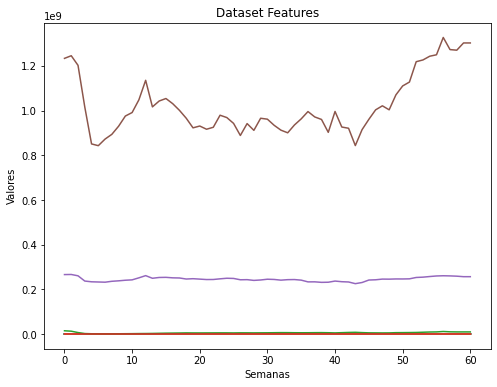

['obitos', 'confirmados_novos', 'recuperados', 'Temperature', 'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio', 'new_cases_per_million_Austria', 'new_deaths_per_million_Austria', 'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium', 'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium', 'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada', 'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada', 'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia', 'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark', 'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France', 'new_cases_per_million_Georgia', 'new_cases_per_million_Germany', 'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany', 'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary', 'positive_rate_India', 'new_cases_per_million_Ireland', 'new_deaths_per_million_Ireland', 'icu_patients_per_million_Irel

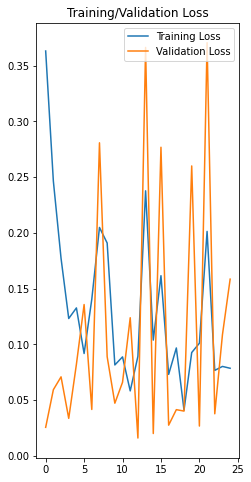

Epoch 1/25
27/27 [==============================] - 0s 3ms/step - loss: 0.1055 - mae: 0.1055 - rmse: 0.1055 - val_loss: 0.2820 - val_mae: 0.2820 - val_rmse: 0.2820
Epoch 2/25
27/27 [==============================] - 0s 2ms/step - loss: 0.1075 - mae: 0.1075 - rmse: 0.1075 - val_loss: 0.1703 - val_mae: 0.1703 - val_rmse: 0.1703
Epoch 3/25
27/27 [==============================] - 0s 2ms/step - loss: 0.1431 - mae: 0.1431 - rmse: 0.1431 - val_loss: 0.1130 - val_mae: 0.1130 - val_rmse: 0.1130
Epoch 4/25
27/27 [==============================] - 0s 2ms/step - loss: 0.1348 - mae: 0.1348 - rmse: 0.1348 - val_loss: 0.2672 - val_mae: 0.2672 - val_rmse: 0.2672
Epoch 5/25
27/27 [==============================] - 0s 2ms/step - loss: 0.1413 - mae: 0.1413 - rmse: 0.1413 - val_loss: 0.2357 - val_mae: 0.2357 - val_rmse: 0.2357
Epoch 6/25
27/27 [==============================] - 0s 2ms/step - loss: 0.1266 - mae: 0.1266 - rmse: 0.1266 - val_loss: 0.1727 - val_mae: 0.1727 - val_rmse: 0.1727
Epoch 7/25
27/27

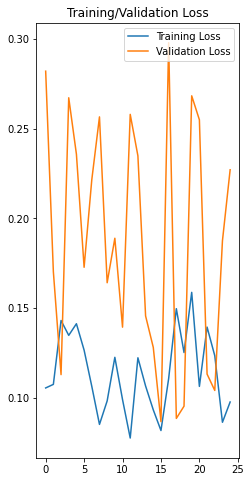

Epoch 1/25
40/40 [==============================] - 0s 3ms/step - loss: 0.1822 - mae: 0.1822 - rmse: 0.1822 - val_loss: 1.2883 - val_mae: 1.2883 - val_rmse: 1.2883
Epoch 2/25
40/40 [==============================] - 0s 2ms/step - loss: 0.1591 - mae: 0.1591 - rmse: 0.1591 - val_loss: 1.0944 - val_mae: 1.0944 - val_rmse: 1.0944
Epoch 3/25
40/40 [==============================] - 0s 2ms/step - loss: 0.1209 - mae: 0.1209 - rmse: 0.1209 - val_loss: 0.9956 - val_mae: 0.9956 - val_rmse: 0.9956
Epoch 4/25
40/40 [==============================] - 0s 2ms/step - loss: 0.1123 - mae: 0.1123 - rmse: 0.1123 - val_loss: 0.9221 - val_mae: 0.9221 - val_rmse: 0.9221
Epoch 5/25
40/40 [==============================] - 0s 3ms/step - loss: 0.0992 - mae: 0.0992 - rmse: 0.0992 - val_loss: 0.8576 - val_mae: 0.8576 - val_rmse: 0.8576
Epoch 6/25
40/40 [==============================] - 0s 2ms/step - loss: 0.1199 - mae: 0.1199 - rmse: 0.1199 - val_loss: 0.6980 - val_mae: 0.6980 - val_rmse: 0.6980
Epoch 7/25
40/40

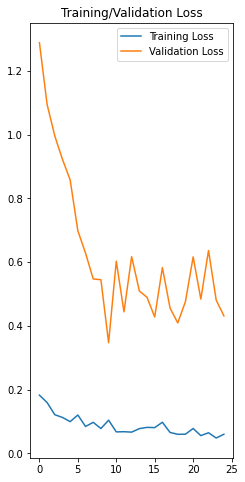

[[-0.92027513 -0.98907104 -0.95624443 -0.93725785 -0.07045291  0.78599222
   0.65485477 -0.35377247  1.         -0.64328341 -0.70843591 -0.75782161
  -0.76899076 -0.26988684 -0.51217565 -0.13936524  0.12751284 -0.69270226
   0.31199613  0.48632739 -0.52153857 -0.482462   -0.7468608  -0.1484868
  -0.00997165 -0.67426232  0.20671277 -0.62537665  0.00576701 -0.07526023
  -0.21727635  1.         -0.92122484 -0.87027262 -0.74180806 -0.89442814
  -0.2844982  -0.75175562  0.00805119 -0.16866547 -0.50387597 -0.37010294
  -0.58583897 -0.36260246  0.19565643 -0.56056374  0.37339919 -0.12270084
  -0.81816357 -0.51891597 -0.32258065 -0.6416187  -0.70905731 -0.59302326
   0.18307113  0.07918196 -0.66276573 -0.22152091 -0.30495875  0.10533489
  -0.79022454 -0.97503952 -0.61394845 -0.84445073 -0.14423449 -0.10522254
  -0.76453366 -0.5380259   0.81776447 -0.65355488 -0.91753152 -0.94881155
  -0.98183478 -0.91748467 -0.94323881 -0.9844358  -0.6990951  -0.73423129
  -0.70131291 -1.          0.85938829  

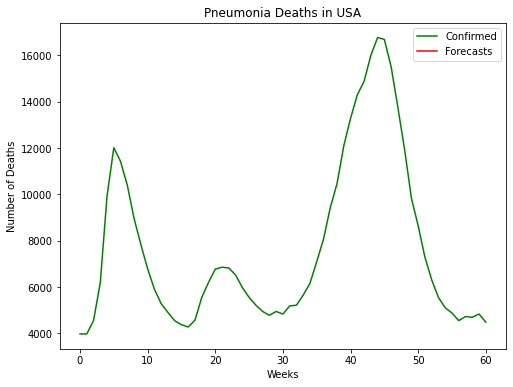

[array([[5528.0127]], dtype=float32)]
Epoch 1/50
8/8 [==============================] - 1s 24ms/step - loss: 0.7765 - mae: 0.7368 - rmse: 0.8004 - val_loss: 1.2924 - val_mae: 1.2924 - val_rmse: 1.2924
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.7388 - mae: 0.6978 - rmse: 0.7607 - val_loss: 1.2199 - val_mae: 1.2199 - val_rmse: 1.2199
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.7049 - mae: 0.6616 - rmse: 0.7247 - val_loss: 1.1475 - val_mae: 1.1475 - val_rmse: 1.1475
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6719 - mae: 0.6283 - rmse: 0.6893 - val_loss: 1.0742 - val_mae: 1.0742 - val_rmse: 1.0742
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6382 - mae: 0.5956 - rmse: 0.6534 - val_loss: 1.0016 - val_mae: 1.0016 - val_rmse: 1.0016
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6056 - mae: 0.5633 - rmse: 0.6187 - val_loss: 0.9307 - val_mae: 0.9307 - val_rm

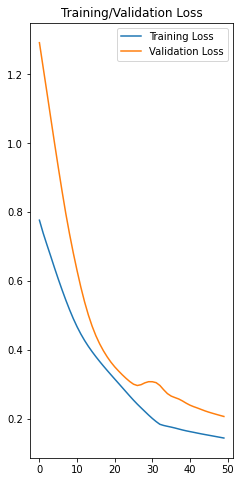

Epoch 1/50
14/14 [==============================] - 0s 6ms/step - loss: 0.1404 - mae: 0.1304 - rmse: 0.1512 - val_loss: 0.3228 - val_mae: 0.3219 - val_rmse: 0.3066
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1327 - mae: 0.1233 - rmse: 0.1422 - val_loss: 0.2949 - val_mae: 0.2942 - val_rmse: 0.2799
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1329 - mae: 0.1244 - rmse: 0.1427 - val_loss: 0.3056 - val_mae: 0.3050 - val_rmse: 0.2907
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1287 - mae: 0.1201 - rmse: 0.1389 - val_loss: 0.3092 - val_mae: 0.3086 - val_rmse: 0.2944
Epoch 5/50
14/14 [==============================] - 0s 5ms/step - loss: 0.1251 - mae: 0.1162 - rmse: 0.1352 - val_loss: 0.3048 - val_mae: 0.3043 - val_rmse: 0.2903
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1232 - mae: 0.1143 - rmse: 0.1332 - val_loss: 0.3019 - val_mae: 0.3014 - val_rmse: 0.2875
Epoch 7/50
14/14

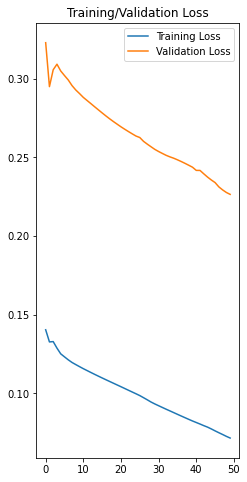

Epoch 1/50
20/20 [==============================] - 0s 10ms/step - loss: 0.1432 - mae: 0.1362 - rmse: 0.1432 - val_loss: 0.6685 - val_mae: 0.6599 - val_rmse: 0.6685
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1453 - mae: 0.1354 - rmse: 0.1453 - val_loss: 0.6641 - val_mae: 0.6580 - val_rmse: 0.6641
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.1375 - mae: 0.1304 - rmse: 0.1375 - val_loss: 0.6759 - val_mae: 0.6668 - val_rmse: 0.6759
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1346 - mae: 0.1273 - rmse: 0.1346 - val_loss: 0.6723 - val_mae: 0.6653 - val_rmse: 0.6723
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1303 - mae: 0.1236 - rmse: 0.1303 - val_loss: 0.6765 - val_mae: 0.6691 - val_rmse: 0.6765
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1287 - mae: 0.1216 - rmse: 0.1287 - val_loss: 0.6780 - val_mae: 0.6709 - val_rmse: 0.6780
Epoch 7/50
20/2

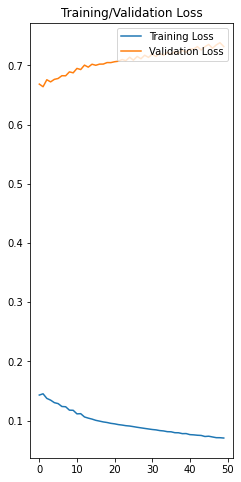

[[-0.92027513 -0.98907104 -0.95624443 -0.93725785 -0.07045291  0.78599222
   0.65485477 -0.35377247  1.         -0.64328341 -0.70843591 -0.75782161
  -0.76899076 -0.26988684 -0.51217565 -0.13936524  0.12751284 -0.69270226
   0.31199613  0.48632739 -0.52153857 -0.482462   -0.7468608  -0.1484868
  -0.00997165 -0.67426232  0.20671277 -0.62537665  0.00576701 -0.07526023
  -0.21727635  1.         -0.92122484 -0.87027262 -0.74180806 -0.89442814
  -0.2844982  -0.75175562  0.00805119 -0.16866547 -0.50387597 -0.37010294
  -0.58583897 -0.36260246  0.19565643 -0.56056374  0.37339919 -0.12270084
  -0.81816357 -0.51891597 -0.32258065 -0.6416187  -0.70905731 -0.59302326
   0.18307113  0.07918196 -0.66276573 -0.22152091 -0.30495875  0.10533489
  -0.79022454 -0.97503952 -0.61394845 -0.84445073 -0.14423449 -0.10522254
  -0.76453366 -0.5380259   0.81776447 -0.65355488 -0.91753152 -0.94881155
  -0.98183478 -0.91748467 -0.94323881 -0.9844358  -0.6990951  -0.73423129
  -0.70131291 -1.          0.85938829  

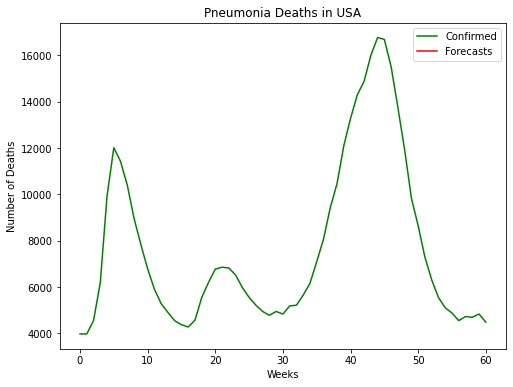

[array([[8308.261]], dtype=float32)]
Epoch 1/100
5/5 [==============================] - 1s 42ms/step - loss: 0.5088 - mae: 0.4866 - rmse: 0.5088 - val_loss: 0.7846 - val_mae: 0.7846 - val_rmse: 0.7846
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.5077 - mae: 0.4856 - rmse: 0.5077 - val_loss: 0.7831 - val_mae: 0.7831 - val_rmse: 0.7831
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5066 - mae: 0.4846 - rmse: 0.5066 - val_loss: 0.7816 - val_mae: 0.7816 - val_rmse: 0.7816
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.5055 - mae: 0.4836 - rmse: 0.5055 - val_loss: 0.7801 - val_mae: 0.7801 - val_rmse: 0.7801
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5044 - mae: 0.4827 - rmse: 0.5044 - val_loss: 0.7786 - val_mae: 0.7786 - val_rmse: 0.7786
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5033 - mae: 0.4817 - rmse: 0.5033 - val_loss: 0.7771 - val_mae: 0.7771 - 

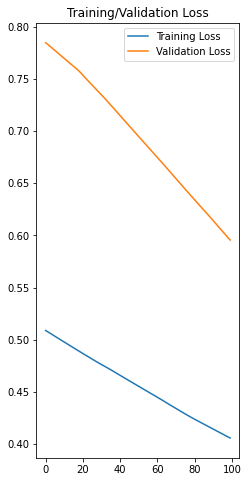

Epoch 1/100
9/9 [==============================] - 0s 22ms/step - loss: 0.3972 - mae: 0.3865 - rmse: 0.3972 - val_loss: 0.4220 - val_mae: 0.4141 - val_rmse: 0.4220
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.3941 - mae: 0.3835 - rmse: 0.3941 - val_loss: 0.4176 - val_mae: 0.4097 - val_rmse: 0.4176
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.3907 - mae: 0.3801 - rmse: 0.3907 - val_loss: 0.4128 - val_mae: 0.4048 - val_rmse: 0.4128
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 0.3871 - mae: 0.3765 - rmse: 0.3871 - val_loss: 0.4079 - val_mae: 0.3998 - val_rmse: 0.4079
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.3835 - mae: 0.3729 - rmse: 0.3835 - val_loss: 0.4029 - val_mae: 0.3947 - val_rmse: 0.4029
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 0.3798 - mae: 0.3692 - rmse: 0.3798 - val_loss: 0.3979 - val_mae: 0.3896 - val_rmse: 0.3979
Epoch 7/100
9/9 [====

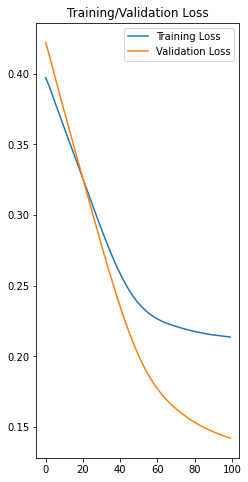

Epoch 1/100
14/14 [==============================] - 0s 6ms/step - loss: 0.2384 - mae: 0.2228 - rmse: 0.2722 - val_loss: 1.5683 - val_mae: 1.5619 - val_rmse: 1.5905
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2372 - mae: 0.2216 - rmse: 0.2706 - val_loss: 1.5618 - val_mae: 1.5554 - val_rmse: 1.5846
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2361 - mae: 0.2205 - rmse: 0.2692 - val_loss: 1.5559 - val_mae: 1.5494 - val_rmse: 1.5792
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2352 - mae: 0.2195 - rmse: 0.2679 - val_loss: 1.5507 - val_mae: 1.5442 - val_rmse: 1.5744
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2343 - mae: 0.2186 - rmse: 0.2667 - val_loss: 1.5460 - val_mae: 1.5394 - val_rmse: 1.5700
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2334 - mae: 0.2178 - rmse: 0.2656 - val_loss: 1.5416 - val_mae: 1.5350 - val_rmse: 1.5660
Epoch 7/10

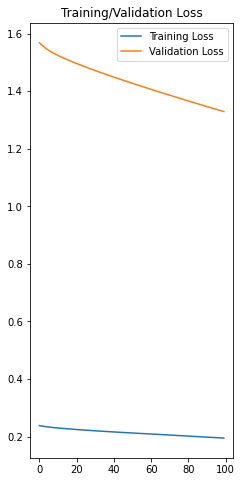

[[-0.92027513 -0.98907104 -0.95624443 -0.93725785 -0.07045291  0.78599222
   0.65485477 -0.35377247  1.         -0.64328341 -0.70843591 -0.75782161
  -0.76899076 -0.26988684 -0.51217565 -0.13936524  0.12751284 -0.69270226
   0.31199613  0.48632739 -0.52153857 -0.482462   -0.7468608  -0.1484868
  -0.00997165 -0.67426232  0.20671277 -0.62537665  0.00576701 -0.07526023
  -0.21727635  1.         -0.92122484 -0.87027262 -0.74180806 -0.89442814
  -0.2844982  -0.75175562  0.00805119 -0.16866547 -0.50387597 -0.37010294
  -0.58583897 -0.36260246  0.19565643 -0.56056374  0.37339919 -0.12270084
  -0.81816357 -0.51891597 -0.32258065 -0.6416187  -0.70905731 -0.59302326
   0.18307113  0.07918196 -0.66276573 -0.22152091 -0.30495875  0.10533489
  -0.79022454 -0.97503952 -0.61394845 -0.84445073 -0.14423449 -0.10522254
  -0.76453366 -0.5380259   0.81776447 -0.65355488 -0.91753152 -0.94881155
  -0.98183478 -0.91748467 -0.94323881 -0.9844358  -0.6990951  -0.73423129
  -0.70131291 -1.          0.85938829  

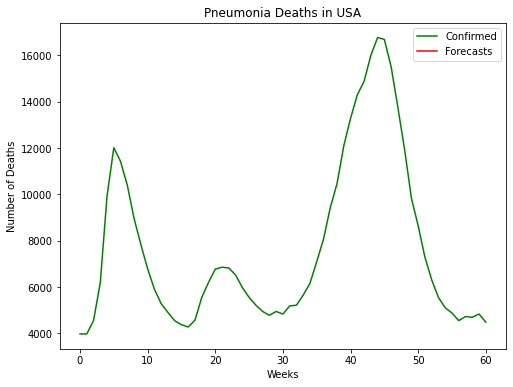

[array([[6970.266]], dtype=float32)]
Epoch 1/60
14/14 [==============================] - 1s 14ms/step - loss: 0.3625 - mae: 0.3625 - rmse: 0.3625 - val_loss: 0.3766 - val_mae: 0.3766 - val_rmse: 0.3766
Epoch 2/60
14/14 [==============================] - 0s 3ms/step - loss: 0.3401 - mae: 0.3401 - rmse: 0.3401 - val_loss: 0.7378 - val_mae: 0.7378 - val_rmse: 0.7378
Epoch 3/60
14/14 [==============================] - 0s 3ms/step - loss: 0.2080 - mae: 0.2080 - rmse: 0.2080 - val_loss: 0.3154 - val_mae: 0.3154 - val_rmse: 0.3154
Epoch 4/60
14/14 [==============================] - 0s 4ms/step - loss: 0.1876 - mae: 0.1876 - rmse: 0.1876 - val_loss: 0.5285 - val_mae: 0.5285 - val_rmse: 0.5285
Epoch 5/60
14/14 [==============================] - 0s 3ms/step - loss: 0.1876 - mae: 0.1876 - rmse: 0.1876 - val_loss: 0.2668 - val_mae: 0.2668 - val_rmse: 0.2668
Epoch 6/60
14/14 [==============================] - 0s 3ms/step - loss: 0.1951 - mae: 0.1951 - rmse: 0.1951 - val_loss: 0.4423 - val_mae: 0.44

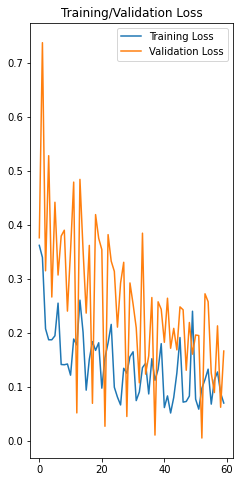

Epoch 1/60
27/27 [==============================] - 0s 3ms/step - loss: 0.1572 - mae: 0.1572 - rmse: 0.1572 - val_loss: 0.1266 - val_mae: 0.1266 - val_rmse: 0.1266
Epoch 2/60
27/27 [==============================] - 0s 2ms/step - loss: 0.1076 - mae: 0.1076 - rmse: 0.1076 - val_loss: 0.1650 - val_mae: 0.1650 - val_rmse: 0.1650
Epoch 3/60
27/27 [==============================] - 0s 2ms/step - loss: 0.1440 - mae: 0.1440 - rmse: 0.1440 - val_loss: 0.1810 - val_mae: 0.1810 - val_rmse: 0.1810
Epoch 4/60
27/27 [==============================] - 0s 2ms/step - loss: 0.1233 - mae: 0.1233 - rmse: 0.1233 - val_loss: 0.0456 - val_mae: 0.0456 - val_rmse: 0.0456
Epoch 5/60
27/27 [==============================] - 0s 2ms/step - loss: 0.1320 - mae: 0.1320 - rmse: 0.1320 - val_loss: 0.0565 - val_mae: 0.0565 - val_rmse: 0.0565
Epoch 6/60
27/27 [==============================] - 0s 2ms/step - loss: 0.1192 - mae: 0.1192 - rmse: 0.1192 - val_loss: 0.0981 - val_mae: 0.0981 - val_rmse: 0.0981
Epoch 7/60
27/27

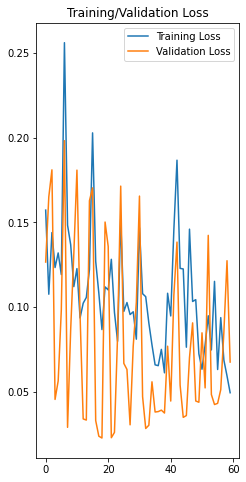

Epoch 1/60
39/39 [==============================] - 0s 3ms/step - loss: 0.1419 - mae: 0.1419 - rmse: 0.1419 - val_loss: 1.0946 - val_mae: 1.0946 - val_rmse: 1.0946
Epoch 2/60
39/39 [==============================] - 0s 2ms/step - loss: 0.0970 - mae: 0.0970 - rmse: 0.0970 - val_loss: 1.0162 - val_mae: 1.0162 - val_rmse: 1.0162
Epoch 3/60
39/39 [==============================] - 0s 2ms/step - loss: 0.0845 - mae: 0.0845 - rmse: 0.0845 - val_loss: 0.9381 - val_mae: 0.9381 - val_rmse: 0.9381
Epoch 4/60
39/39 [==============================] - 0s 2ms/step - loss: 0.0748 - mae: 0.0748 - rmse: 0.0748 - val_loss: 0.8172 - val_mae: 0.8172 - val_rmse: 0.8172
Epoch 5/60
39/39 [==============================] - 0s 3ms/step - loss: 0.0810 - mae: 0.0810 - rmse: 0.0810 - val_loss: 0.8895 - val_mae: 0.8895 - val_rmse: 0.8895
Epoch 6/60
39/39 [==============================] - 0s 2ms/step - loss: 0.1325 - mae: 0.1325 - rmse: 0.1325 - val_loss: 0.7730 - val_mae: 0.7730 - val_rmse: 0.7730
Epoch 7/60
39/39

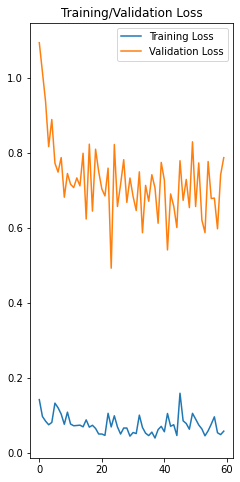

[[-0.86556198 -0.97118728 -0.91880911 -0.89841389 -0.06542056  0.3618677
   0.14154056 -0.03218847 -0.4123767  -0.3540587  -0.51936649 -0.59130229
  -0.66946753  0.27950955 -0.15389717  0.58087227  1.         -0.51043367
   1.          1.         -0.1809098   0.05196264 -0.60810036  0.45643271
   0.71506982 -0.53766911  0.74654742 -0.49486659  0.66639589  1.
   0.63474803  0.53093525 -0.88793874 -0.78240344 -0.53445389 -0.80014589
   0.14129866 -0.75280899  0.78762997  0.33046833 -0.28568728  0.05388307
  -0.20708052  0.09003001  1.         -0.2411861   1.          0.43558499
  -0.36361264 -0.11842591 -0.25       -0.6416187  -0.41354034 -0.57953488
   1.          0.30676455 -0.39818198  0.32973384  0.27998639  0.20560748
  -0.52646319 -0.94468974 -0.21493503 -0.77778676  0.44927187  0.32338564
  -0.74289127 -0.16814312  0.86427146 -0.58606557 -0.89595156 -0.91213735
  -0.95700586 -0.82904768 -0.8841291  -0.98110061 -0.45146822 -0.57170885
  -0.66356674 -0.96524487  0.90145488  0.294696

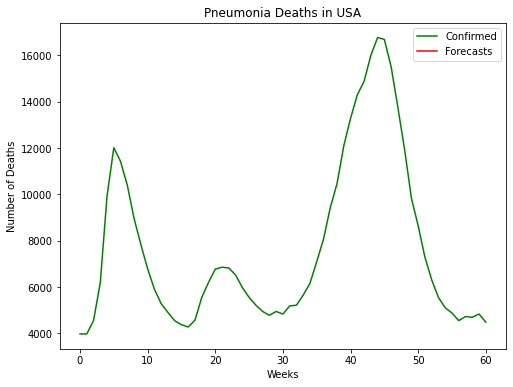

[array([[5436.284]], dtype=float32)]
Epoch 1/90
7/7 [==============================] - 1s 30ms/step - loss: 1.0223 - mae: 1.0173 - rmse: 1.0223 - val_loss: 1.1729 - val_mae: 1.1729 - val_rmse: 1.1729
Epoch 2/90
7/7 [==============================] - 0s 6ms/step - loss: 0.9172 - mae: 0.9112 - rmse: 0.9172 - val_loss: 1.0520 - val_mae: 1.0520 - val_rmse: 1.0520
Epoch 3/90
7/7 [==============================] - 0s 8ms/step - loss: 0.8144 - mae: 0.8072 - rmse: 0.8144 - val_loss: 0.9288 - val_mae: 0.9288 - val_rmse: 0.9288
Epoch 4/90
7/7 [==============================] - 0s 8ms/step - loss: 0.7125 - mae: 0.7034 - rmse: 0.7125 - val_loss: 0.8042 - val_mae: 0.8042 - val_rmse: 0.8042
Epoch 5/90
7/7 [==============================] - 0s 6ms/step - loss: 0.6127 - mae: 0.6009 - rmse: 0.6127 - val_loss: 0.6804 - val_mae: 0.6804 - val_rmse: 0.6804
Epoch 6/90
7/7 [==============================] - 0s 6ms/step - loss: 0.5344 - mae: 0.5201 - rmse: 0.5344 - val_loss: 0.5703 - val_mae: 0.5703 - val_rms

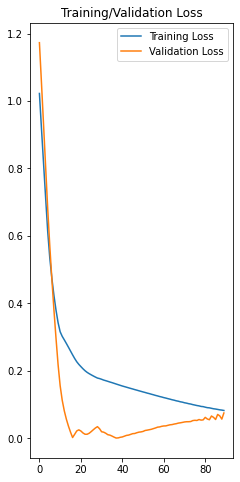

Epoch 1/90
14/14 [==============================] - 0s 14ms/step - loss: 0.1010 - mae: 0.0970 - rmse: 0.1007 - val_loss: 0.2485 - val_mae: 0.2467 - val_rmse: 0.2485
Epoch 2/90
14/14 [==============================] - 0s 4ms/step - loss: 0.0980 - mae: 0.0938 - rmse: 0.0983 - val_loss: 0.2600 - val_mae: 0.2584 - val_rmse: 0.2600
Epoch 3/90
14/14 [==============================] - 0s 4ms/step - loss: 0.0948 - mae: 0.0901 - rmse: 0.0957 - val_loss: 0.2734 - val_mae: 0.2719 - val_rmse: 0.2734
Epoch 4/90
14/14 [==============================] - 0s 6ms/step - loss: 0.0935 - mae: 0.0887 - rmse: 0.0945 - val_loss: 0.2743 - val_mae: 0.2729 - val_rmse: 0.2743
Epoch 5/90
14/14 [==============================] - 0s 5ms/step - loss: 0.0909 - mae: 0.0856 - rmse: 0.0926 - val_loss: 0.2886 - val_mae: 0.2874 - val_rmse: 0.2886
Epoch 6/90
14/14 [==============================] - 0s 5ms/step - loss: 0.0906 - mae: 0.0853 - rmse: 0.0920 - val_loss: 0.2801 - val_mae: 0.2789 - val_rmse: 0.2801
Epoch 7/90
14/1

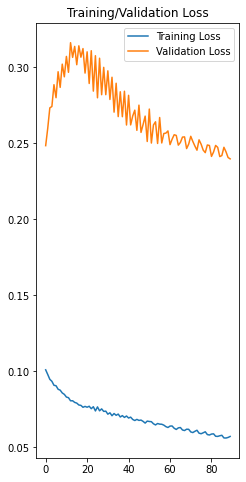

Epoch 1/90
20/20 [==============================] - 0s 5ms/step - loss: 0.0941 - mae: 0.0885 - rmse: 0.0969 - val_loss: 0.3785 - val_mae: 0.3691 - val_rmse: 0.3785
Epoch 2/90
20/20 [==============================] - 0s 3ms/step - loss: 0.0914 - mae: 0.0860 - rmse: 0.0932 - val_loss: 0.3533 - val_mae: 0.3429 - val_rmse: 0.3533
Epoch 3/90
20/20 [==============================] - 0s 3ms/step - loss: 0.0867 - mae: 0.0815 - rmse: 0.0877 - val_loss: 0.3309 - val_mae: 0.3195 - val_rmse: 0.3309
Epoch 4/90
20/20 [==============================] - 0s 3ms/step - loss: 0.0832 - mae: 0.0784 - rmse: 0.0833 - val_loss: 0.3100 - val_mae: 0.2966 - val_rmse: 0.3100
Epoch 5/90
20/20 [==============================] - 0s 3ms/step - loss: 0.0807 - mae: 0.0760 - rmse: 0.0799 - val_loss: 0.2856 - val_mae: 0.2700 - val_rmse: 0.2856
Epoch 6/90
20/20 [==============================] - 0s 4ms/step - loss: 0.0790 - mae: 0.0740 - rmse: 0.0776 - val_loss: 0.2688 - val_mae: 0.2508 - val_rmse: 0.2688
Epoch 7/90
20/20

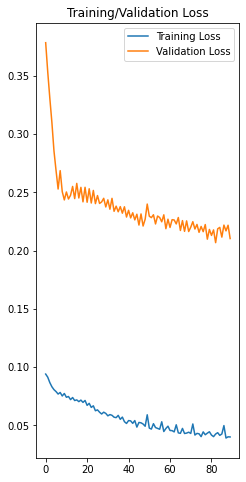

[[-0.86556198 -0.97118728 -0.91880911 -0.89841389 -0.06542056  0.3618677
   0.14154056 -0.03218847 -0.4123767  -0.3540587  -0.51936649 -0.59130229
  -0.66946753  0.27950955 -0.15389717  0.58087227  1.         -0.51043367
   1.          1.         -0.1809098   0.05196264 -0.60810036  0.45643271
   0.71506982 -0.53766911  0.74654742 -0.49486659  0.66639589  1.
   0.63474803  0.53093525 -0.88793874 -0.78240344 -0.53445389 -0.80014589
   0.14129866 -0.75280899  0.78762997  0.33046833 -0.28568728  0.05388307
  -0.20708052  0.09003001  1.         -0.2411861   1.          0.43558499
  -0.36361264 -0.11842591 -0.25       -0.6416187  -0.41354034 -0.57953488
   1.          0.30676455 -0.39818198  0.32973384  0.27998639  0.20560748
  -0.52646319 -0.94468974 -0.21493503 -0.77778676  0.44927187  0.32338564
  -0.74289127 -0.16814312  0.86427146 -0.58606557 -0.89595156 -0.91213735
  -0.95700586 -0.82904768 -0.8841291  -0.98110061 -0.45146822 -0.57170885
  -0.66356674 -0.96524487  0.90145488  0.294696

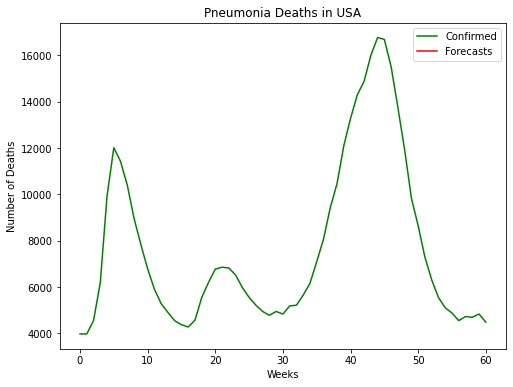

[array([[7855.3667]], dtype=float32)]
Epoch 1/120
5/5 [==============================] - 1s 47ms/step - loss: 0.7832 - mae: 0.7326 - rmse: 0.8132 - val_loss: 1.1106 - val_mae: 1.1106 - val_rmse: 1.1106
Epoch 2/120
5/5 [==============================] - 0s 10ms/step - loss: 0.7807 - mae: 0.7299 - rmse: 0.8106 - val_loss: 1.1067 - val_mae: 1.1067 - val_rmse: 1.1067
Epoch 3/120
5/5 [==============================] - 0s 9ms/step - loss: 0.7783 - mae: 0.7273 - rmse: 0.8081 - val_loss: 1.1027 - val_mae: 1.1027 - val_rmse: 1.1027
Epoch 4/120
5/5 [==============================] - 0s 9ms/step - loss: 0.7758 - mae: 0.7247 - rmse: 0.8055 - val_loss: 1.0986 - val_mae: 1.0986 - val_rmse: 1.0986
Epoch 5/120
5/5 [==============================] - 0s 13ms/step - loss: 0.7734 - mae: 0.7221 - rmse: 0.8030 - val_loss: 1.0945 - val_mae: 1.0945 - val_rmse: 1.0945
Epoch 6/120
5/5 [==============================] - 0s 11ms/step - loss: 0.7709 - mae: 0.7195 - rmse: 0.8004 - val_loss: 1.0905 - val_mae: 1.0905

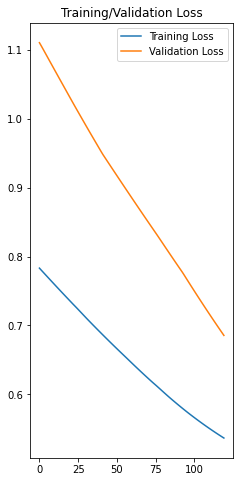

Epoch 1/120
9/9 [==============================] - 0s 9ms/step - loss: 0.5086 - mae: 0.4932 - rmse: 0.5086 - val_loss: 0.4513 - val_mae: 0.4494 - val_rmse: 0.4513
Epoch 2/120
9/9 [==============================] - 0s 6ms/step - loss: 0.5028 - mae: 0.4872 - rmse: 0.5028 - val_loss: 0.4428 - val_mae: 0.4409 - val_rmse: 0.4428
Epoch 3/120
9/9 [==============================] - 0s 6ms/step - loss: 0.4964 - mae: 0.4805 - rmse: 0.4964 - val_loss: 0.4336 - val_mae: 0.4317 - val_rmse: 0.4336
Epoch 4/120
9/9 [==============================] - 0s 6ms/step - loss: 0.4899 - mae: 0.4736 - rmse: 0.4899 - val_loss: 0.4242 - val_mae: 0.4223 - val_rmse: 0.4242
Epoch 5/120
9/9 [==============================] - 0s 6ms/step - loss: 0.4834 - mae: 0.4667 - rmse: 0.4834 - val_loss: 0.4149 - val_mae: 0.4129 - val_rmse: 0.4149
Epoch 6/120
9/9 [==============================] - 0s 6ms/step - loss: 0.4769 - mae: 0.4598 - rmse: 0.4769 - val_loss: 0.4055 - val_mae: 0.4035 - val_rmse: 0.4055
Epoch 7/120
9/9 [=====

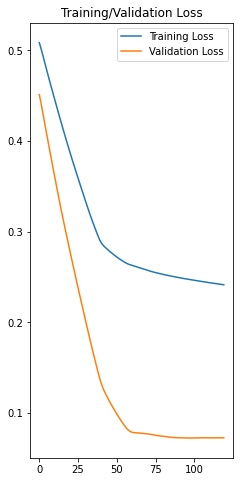

Epoch 1/120
13/13 [==============================] - 0s 7ms/step - loss: 0.2101 - mae: 0.1921 - rmse: 0.2101 - val_loss: 0.6603 - val_mae: 0.6451 - val_rmse: 0.7690
Epoch 2/120
13/13 [==============================] - 0s 5ms/step - loss: 0.2089 - mae: 0.1911 - rmse: 0.2089 - val_loss: 0.6611 - val_mae: 0.6458 - val_rmse: 0.7697
Epoch 3/120
13/13 [==============================] - 0s 5ms/step - loss: 0.2080 - mae: 0.1902 - rmse: 0.2080 - val_loss: 0.6617 - val_mae: 0.6463 - val_rmse: 0.7703
Epoch 4/120
13/13 [==============================] - 0s 4ms/step - loss: 0.2073 - mae: 0.1895 - rmse: 0.2073 - val_loss: 0.6621 - val_mae: 0.6467 - val_rmse: 0.7708
Epoch 5/120
13/13 [==============================] - 0s 5ms/step - loss: 0.2066 - mae: 0.1888 - rmse: 0.2066 - val_loss: 0.6624 - val_mae: 0.6470 - val_rmse: 0.7711
Epoch 6/120
13/13 [==============================] - 0s 4ms/step - loss: 0.2060 - mae: 0.1882 - rmse: 0.2060 - val_loss: 0.6625 - val_mae: 0.6471 - val_rmse: 0.7713
Epoch 7/12

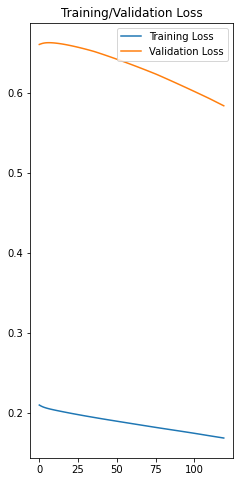

[[-0.86556198 -0.97118728 -0.91880911 -0.89841389 -0.06542056  0.3618677
   0.14154056 -0.03218847 -0.4123767  -0.3540587  -0.51936649 -0.59130229
  -0.66946753  0.27950955 -0.15389717  0.58087227  1.         -0.51043367
   1.          1.         -0.1809098   0.05196264 -0.60810036  0.45643271
   0.71506982 -0.53766911  0.74654742 -0.49486659  0.66639589  1.
   0.63474803  0.53093525 -0.88793874 -0.78240344 -0.53445389 -0.80014589
   0.14129866 -0.75280899  0.78762997  0.33046833 -0.28568728  0.05388307
  -0.20708052  0.09003001  1.         -0.2411861   1.          0.43558499
  -0.36361264 -0.11842591 -0.25       -0.6416187  -0.41354034 -0.57953488
   1.          0.30676455 -0.39818198  0.32973384  0.27998639  0.20560748
  -0.52646319 -0.94468974 -0.21493503 -0.77778676  0.44927187  0.32338564
  -0.74289127 -0.16814312  0.86427146 -0.58606557 -0.89595156 -0.91213735
  -0.95700586 -0.82904768 -0.8841291  -0.98110061 -0.45146822 -0.57170885
  -0.66356674 -0.96524487  0.90145488  0.294696

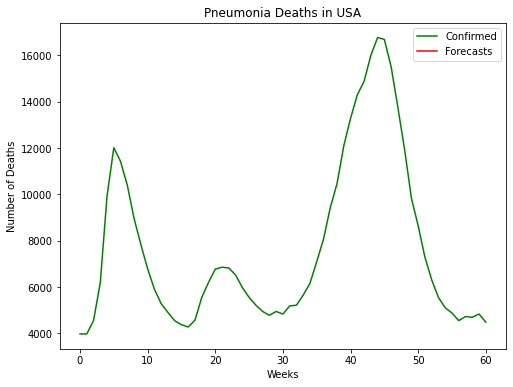

[array([[7180.892]], dtype=float32)]
Epoch 1/50
12/12 [==============================] - 1s 16ms/step - loss: 0.6672 - mae: 0.6672 - rmse: 0.6672 - val_loss: 0.4278 - val_mae: 0.4278 - val_rmse: 0.4278
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5156 - mae: 0.5156 - rmse: 0.5156 - val_loss: 0.3680 - val_mae: 0.3680 - val_rmse: 0.3680
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2520 - mae: 0.2520 - rmse: 0.2520 - val_loss: 0.4204 - val_mae: 0.4204 - val_rmse: 0.4204
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0925 - mae: 0.0925 - rmse: 0.0925 - val_loss: 0.1758 - val_mae: 0.1758 - val_rmse: 0.1758
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1132 - mae: 0.1132 - rmse: 0.1132 - val_loss: 0.3220 - val_mae: 0.3220 - val_rmse: 0.3220
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1981 - mae: 0.1981 - rmse: 0.1981 - val_loss: 0.1508 - val_mae: 0.15

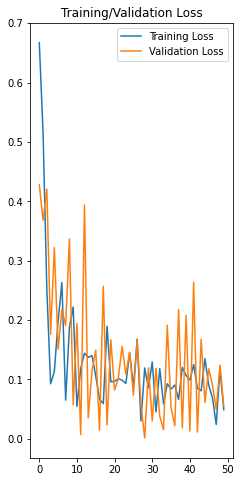

Epoch 1/50
25/25 [==============================] - 0s 4ms/step - loss: 0.1726 - mae: 0.1726 - rmse: 0.1726 - val_loss: 0.4234 - val_mae: 0.4234 - val_rmse: 0.4234
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1515 - mae: 0.1515 - rmse: 0.1515 - val_loss: 0.2826 - val_mae: 0.2826 - val_rmse: 0.2826
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.1591 - mae: 0.1591 - rmse: 0.1591 - val_loss: 0.1843 - val_mae: 0.1843 - val_rmse: 0.1843
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.1247 - mae: 0.1247 - rmse: 0.1247 - val_loss: 0.2918 - val_mae: 0.2918 - val_rmse: 0.2918
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.1235 - mae: 0.1235 - rmse: 0.1235 - val_loss: 0.2547 - val_mae: 0.2547 - val_rmse: 0.2547
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0997 - mae: 0.0997 - rmse: 0.0997 - val_loss: 0.2389 - val_mae: 0.2389 - val_rmse: 0.2389
Epoch 7/50
25/25

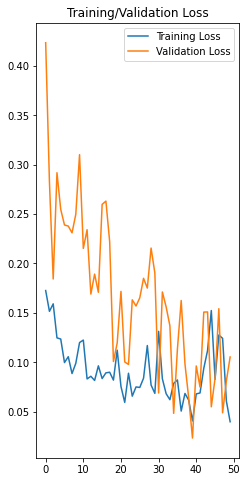

Epoch 1/50
37/37 [==============================] - 0s 3ms/step - loss: 0.1278 - mae: 0.1278 - rmse: 0.1278 - val_loss: 0.6266 - val_mae: 0.6266 - val_rmse: 0.6266
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.1115 - mae: 0.1115 - rmse: 0.1115 - val_loss: 0.1744 - val_mae: 0.1744 - val_rmse: 0.1744
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0945 - mae: 0.0945 - rmse: 0.0945 - val_loss: 0.8081 - val_mae: 0.8081 - val_rmse: 0.8081
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.1172 - mae: 0.1172 - rmse: 0.1172 - val_loss: 0.7379 - val_mae: 0.7379 - val_rmse: 0.7379
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0712 - mae: 0.0712 - rmse: 0.0712 - val_loss: 0.6001 - val_mae: 0.6001 - val_rmse: 0.6001
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0986 - mae: 0.0986 - rmse: 0.0986 - val_loss: 0.4411 - val_mae: 0.4411 - val_rmse: 0.4411
Epoch 7/50
37/37

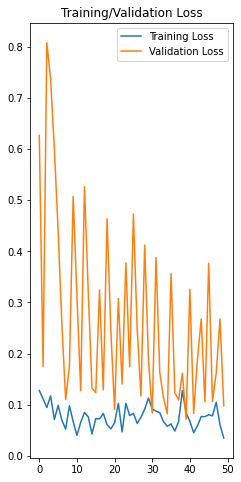

[[-8.82444896e-01 -9.58271237e-01 -9.32213592e-01 -8.76346311e-01
  -6.47016535e-03  1.67315175e-01 -2.56497135e-01 -2.47669739e-01
  -8.02332886e-01 -1.22757865e-01 -5.60376662e-01 -4.95974698e-01
  -6.71259255e-01  7.56226766e-02 -1.89799282e-01  7.88393299e-01
   2.57588839e-01 -6.83434367e-01  3.17007550e-01  2.96591879e-01
   4.19501810e-01  5.92306426e-01 -5.70594847e-01  3.37231165e-01
   4.95200498e-01 -7.65545844e-01  3.60212393e-01 -6.41683596e-01
   3.32838433e-01  9.72850332e-01  1.00000000e+00 -2.61664954e-01
  -8.42274516e-01 -7.78230014e-01 -4.02008805e-01 -7.12610028e-01
   3.25435962e-01 -7.03651685e-01  8.46814183e-01 -2.26774978e-01
  -5.28077141e-01 -1.33079012e-01 -3.72798500e-01  8.21909233e-02
   7.07358187e-01 -4.23513549e-01  3.70002011e-01  2.33129859e-01
   1.00351229e-04 -2.10341417e-02 -1.73387097e-01 -1.09826065e-01
   1.14364175e-01 -4.55813953e-01  6.93159070e-01  7.29417934e-01
  -3.94019278e-01  3.49581749e-01  3.39967679e-01  6.54205607e-01
  -2.93164

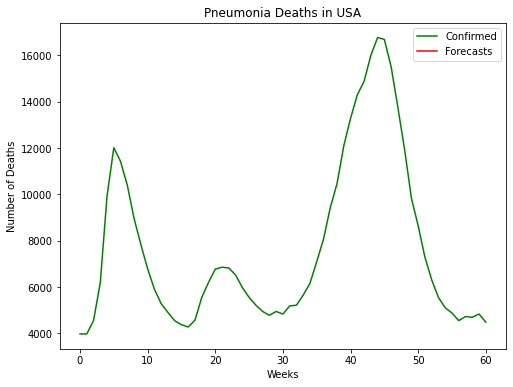

[array([[8152.409]], dtype=float32)]
Epoch 1/90
6/6 [==============================] - 1s 41ms/step - loss: 0.5794 - mae: 0.5595 - rmse: 0.5794 - val_loss: 0.9715 - val_mae: 0.9715 - val_rmse: 0.9715
Epoch 2/90
6/6 [==============================] - 0s 8ms/step - loss: 0.5461 - mae: 0.5301 - rmse: 0.5461 - val_loss: 0.9349 - val_mae: 0.9349 - val_rmse: 0.9349
Epoch 3/90
6/6 [==============================] - 0s 7ms/step - loss: 0.5176 - mae: 0.5006 - rmse: 0.5176 - val_loss: 0.8965 - val_mae: 0.8965 - val_rmse: 0.8965
Epoch 4/90
6/6 [==============================] - 0s 9ms/step - loss: 0.4911 - mae: 0.4726 - rmse: 0.4911 - val_loss: 0.8575 - val_mae: 0.8575 - val_rmse: 0.8575
Epoch 5/90
6/6 [==============================] - 0s 8ms/step - loss: 0.4657 - mae: 0.4480 - rmse: 0.4657 - val_loss: 0.8174 - val_mae: 0.8174 - val_rmse: 0.8174
Epoch 6/90
6/6 [==============================] - 0s 8ms/step - loss: 0.4404 - mae: 0.4230 - rmse: 0.4404 - val_loss: 0.7780 - val_mae: 0.7780 - val_rms

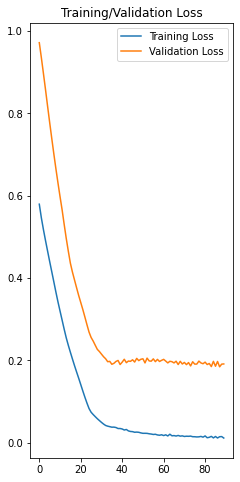

Epoch 1/90
13/13 [==============================] - 0s 16ms/step - loss: 0.1157 - mae: 0.1121 - rmse: 0.1315 - val_loss: 0.3900 - val_mae: 0.3886 - val_rmse: 0.3900
Epoch 2/90
13/13 [==============================] - 0s 4ms/step - loss: 0.1215 - mae: 0.1178 - rmse: 0.1368 - val_loss: 0.4013 - val_mae: 0.3999 - val_rmse: 0.4013
Epoch 3/90
13/13 [==============================] - 0s 5ms/step - loss: 0.1082 - mae: 0.1041 - rmse: 0.1225 - val_loss: 0.3857 - val_mae: 0.3842 - val_rmse: 0.3857
Epoch 4/90
13/13 [==============================] - 0s 5ms/step - loss: 0.1077 - mae: 0.1037 - rmse: 0.1217 - val_loss: 0.4030 - val_mae: 0.4015 - val_rmse: 0.4030
Epoch 5/90
13/13 [==============================] - 0s 5ms/step - loss: 0.1001 - mae: 0.0952 - rmse: 0.1124 - val_loss: 0.3728 - val_mae: 0.3713 - val_rmse: 0.3728
Epoch 6/90
13/13 [==============================] - 0s 5ms/step - loss: 0.0954 - mae: 0.0911 - rmse: 0.1076 - val_loss: 0.3870 - val_mae: 0.3854 - val_rmse: 0.3870
Epoch 7/90
13/1

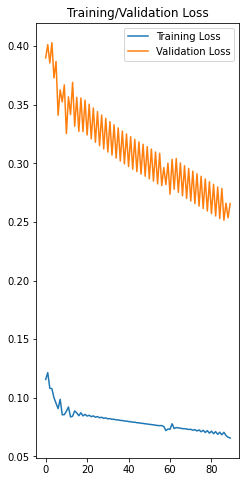

Epoch 1/90
19/19 [==============================] - 0s 5ms/step - loss: 0.1733 - mae: 0.1660 - rmse: 0.1922 - val_loss: 0.9152 - val_mae: 0.9022 - val_rmse: 0.9152
Epoch 2/90
19/19 [==============================] - 0s 4ms/step - loss: 0.1689 - mae: 0.1617 - rmse: 0.1848 - val_loss: 0.8591 - val_mae: 0.8445 - val_rmse: 0.8591
Epoch 3/90
19/19 [==============================] - 0s 6ms/step - loss: 0.1556 - mae: 0.1487 - rmse: 0.1704 - val_loss: 0.8416 - val_mae: 0.8266 - val_rmse: 0.8416
Epoch 4/90
19/19 [==============================] - 0s 4ms/step - loss: 0.1580 - mae: 0.1515 - rmse: 0.1710 - val_loss: 0.8096 - val_mae: 0.7936 - val_rmse: 0.8096
Epoch 5/90
19/19 [==============================] - 0s 5ms/step - loss: 0.1447 - mae: 0.1379 - rmse: 0.1570 - val_loss: 0.7997 - val_mae: 0.7834 - val_rmse: 0.7997
Epoch 6/90
19/19 [==============================] - 0s 4ms/step - loss: 0.1428 - mae: 0.1363 - rmse: 0.1539 - val_loss: 0.7835 - val_mae: 0.7664 - val_rmse: 0.7835
Epoch 7/90
19/19

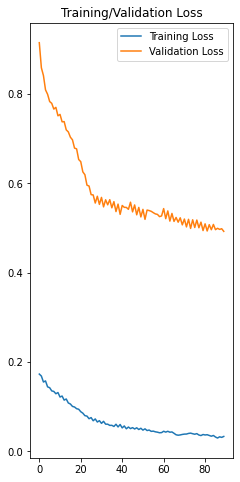

[[-8.82444896e-01 -9.58271237e-01 -9.32213592e-01 -8.76346311e-01
  -6.47016535e-03  1.67315175e-01 -2.56497135e-01 -2.47669739e-01
  -8.02332886e-01 -1.22757865e-01 -5.60376662e-01 -4.95974698e-01
  -6.71259255e-01  7.56226766e-02 -1.89799282e-01  7.88393299e-01
   2.57588839e-01 -6.83434367e-01  3.17007550e-01  2.96591879e-01
   4.19501810e-01  5.92306426e-01 -5.70594847e-01  3.37231165e-01
   4.95200498e-01 -7.65545844e-01  3.60212393e-01 -6.41683596e-01
   3.32838433e-01  9.72850332e-01  1.00000000e+00 -2.61664954e-01
  -8.42274516e-01 -7.78230014e-01 -4.02008805e-01 -7.12610028e-01
   3.25435962e-01 -7.03651685e-01  8.46814183e-01 -2.26774978e-01
  -5.28077141e-01 -1.33079012e-01 -3.72798500e-01  8.21909233e-02
   7.07358187e-01 -4.23513549e-01  3.70002011e-01  2.33129859e-01
   1.00351229e-04 -2.10341417e-02 -1.73387097e-01 -1.09826065e-01
   1.14364175e-01 -4.55813953e-01  6.93159070e-01  7.29417934e-01
  -3.94019278e-01  3.49581749e-01  3.39967679e-01  6.54205607e-01
  -2.93164

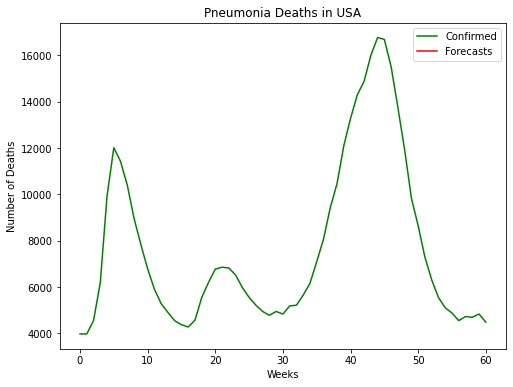

[array([[12336.786]], dtype=float32)]
Epoch 1/120
4/4 [==============================] - 1s 59ms/step - loss: 1.2543 - mae: 1.2244 - rmse: 1.2543 - val_loss: 1.9386 - val_mae: 1.9386 - val_rmse: 1.9386
Epoch 2/120
4/4 [==============================] - 0s 11ms/step - loss: 1.2487 - mae: 1.2186 - rmse: 1.2487 - val_loss: 1.9316 - val_mae: 1.9316 - val_rmse: 1.9316
Epoch 3/120
4/4 [==============================] - 0s 12ms/step - loss: 1.2431 - mae: 1.2130 - rmse: 1.2431 - val_loss: 1.9246 - val_mae: 1.9246 - val_rmse: 1.9246
Epoch 4/120
4/4 [==============================] - 0s 14ms/step - loss: 1.2376 - mae: 1.2073 - rmse: 1.2376 - val_loss: 1.9177 - val_mae: 1.9177 - val_rmse: 1.9177
Epoch 5/120
4/4 [==============================] - 0s 10ms/step - loss: 1.2321 - mae: 1.2017 - rmse: 1.2321 - val_loss: 1.9108 - val_mae: 1.9108 - val_rmse: 1.9108
Epoch 6/120
4/4 [==============================] - 0s 11ms/step - loss: 1.2266 - mae: 1.1961 - rmse: 1.2266 - val_loss: 1.9040 - val_mae: 1.90

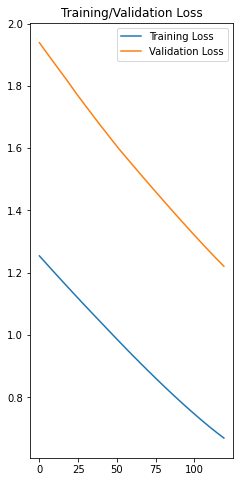

Epoch 1/120
9/9 [==============================] - 0s 12ms/step - loss: 0.7860 - mae: 0.7630 - rmse: 0.8000 - val_loss: 0.9142 - val_mae: 0.9140 - val_rmse: 0.9142
Epoch 2/120
9/9 [==============================] - 0s 7ms/step - loss: 0.7751 - mae: 0.7528 - rmse: 0.7890 - val_loss: 0.9013 - val_mae: 0.9011 - val_rmse: 0.9013
Epoch 3/120
9/9 [==============================] - 0s 7ms/step - loss: 0.7637 - mae: 0.7422 - rmse: 0.7773 - val_loss: 0.8890 - val_mae: 0.8887 - val_rmse: 0.8890
Epoch 4/120
9/9 [==============================] - 0s 8ms/step - loss: 0.7521 - mae: 0.7320 - rmse: 0.7656 - val_loss: 0.8765 - val_mae: 0.8762 - val_rmse: 0.8765
Epoch 5/120
9/9 [==============================] - 0s 6ms/step - loss: 0.7407 - mae: 0.7219 - rmse: 0.7541 - val_loss: 0.8640 - val_mae: 0.8638 - val_rmse: 0.8640
Epoch 6/120
9/9 [==============================] - 0s 7ms/step - loss: 0.7295 - mae: 0.7119 - rmse: 0.7427 - val_loss: 0.8516 - val_mae: 0.8514 - val_rmse: 0.8516
Epoch 7/120
9/9 [====

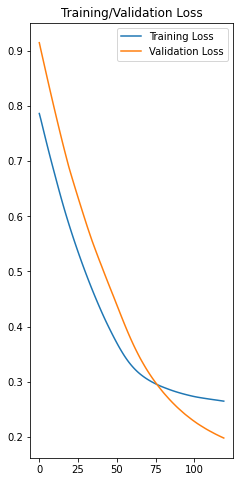

Epoch 1/120
13/13 [==============================] - 0s 8ms/step - loss: 0.3120 - mae: 0.2884 - rmse: 0.3497 - val_loss: 0.8288 - val_mae: 0.7956 - val_rmse: 0.7405
Epoch 2/120
13/13 [==============================] - 0s 5ms/step - loss: 0.3108 - mae: 0.2873 - rmse: 0.3482 - val_loss: 0.8247 - val_mae: 0.7913 - val_rmse: 0.7372
Epoch 3/120
13/13 [==============================] - 0s 6ms/step - loss: 0.3096 - mae: 0.2863 - rmse: 0.3469 - val_loss: 0.8210 - val_mae: 0.7874 - val_rmse: 0.7342
Epoch 4/120
13/13 [==============================] - 0s 6ms/step - loss: 0.3086 - mae: 0.2853 - rmse: 0.3456 - val_loss: 0.8178 - val_mae: 0.7839 - val_rmse: 0.7316
Epoch 5/120
13/13 [==============================] - 0s 5ms/step - loss: 0.3076 - mae: 0.2844 - rmse: 0.3445 - val_loss: 0.8149 - val_mae: 0.7809 - val_rmse: 0.7293
Epoch 6/120
13/13 [==============================] - 0s 6ms/step - loss: 0.3066 - mae: 0.2835 - rmse: 0.3434 - val_loss: 0.8124 - val_mae: 0.7781 - val_rmse: 0.7271
Epoch 7/12

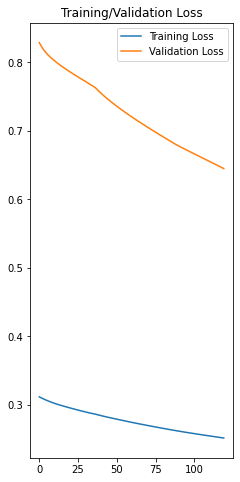

[[-8.82444896e-01 -9.58271237e-01 -9.32213592e-01 -8.76346311e-01
  -6.47016535e-03  1.67315175e-01 -2.56497135e-01 -2.47669739e-01
  -8.02332886e-01 -1.22757865e-01 -5.60376662e-01 -4.95974698e-01
  -6.71259255e-01  7.56226766e-02 -1.89799282e-01  7.88393299e-01
   2.57588839e-01 -6.83434367e-01  3.17007550e-01  2.96591879e-01
   4.19501810e-01  5.92306426e-01 -5.70594847e-01  3.37231165e-01
   4.95200498e-01 -7.65545844e-01  3.60212393e-01 -6.41683596e-01
   3.32838433e-01  9.72850332e-01  1.00000000e+00 -2.61664954e-01
  -8.42274516e-01 -7.78230014e-01 -4.02008805e-01 -7.12610028e-01
   3.25435962e-01 -7.03651685e-01  8.46814183e-01 -2.26774978e-01
  -5.28077141e-01 -1.33079012e-01 -3.72798500e-01  8.21909233e-02
   7.07358187e-01 -4.23513549e-01  3.70002011e-01  2.33129859e-01
   1.00351229e-04 -2.10341417e-02 -1.73387097e-01 -1.09826065e-01
   1.14364175e-01 -4.55813953e-01  6.93159070e-01  7.29417934e-01
  -3.94019278e-01  3.49581749e-01  3.39967679e-01  6.54205607e-01
  -2.93164

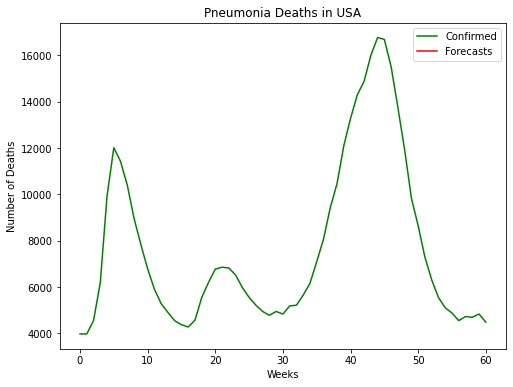

[array([[11005.243]], dtype=float32)]


In [ ]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('dataset_final_semanal.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {               
                1: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   learning_rate = tunning_dict[t]['learning_rate']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
   path_to_save=r'modelo_auxclose'+str(t)+'.h5'
   model.save(path_to_save)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)
   plot_forecast(df_data, forecasts)
   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




Criação de uma tabela com os resultados obtidos para cada optimização

In [ ]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.11152973135312398, 0.11152973135312398, 0.11152973135312398, 0.3078657542665799, 0.3078657542665799, 0.3078657542665799] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.1723331004877885, 0.16145774438977242, 0.1765217533707619, 0.4749164700508118, 0.471321150759856, 0.46964819788932805] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.3120837134619554, 0.2978960817058881, 0.32081542874375973, 0.7871073423822721, 0.779392545496424, 0.7975114196538925] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.10837426367733212, 0.10837426367733212, 0.10837426367733212, 0.3536626070737839, 0.3536626070737839, 0.3536626070737839] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.10960238175811592, 0.1034632607742592, 0.10983898060189352, 0.20389229428988917, 0.19561116000016532, 0.20389229428988

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.111530,0.111530,0.111530,0.307866,0.307866,0.307866
2,0.172333,0.161458,0.176522,0.474916,0.471321,0.469648
3,0.312084,0.297896,0.320815,0.787107,0.779393,0.797511
4,0.108374,0.108374,0.108374,0.353663,0.353663,0.353663
5,0.109602,0.103463,0.109839,0.203892,0.195611,0.203892
6,0.379726,0.354799,0.386966,0.556863,0.548708,0.594863
7,0.099632,0.099632,0.099632,0.190068,0.190068,0.190068
8,0.082921,0.078657,0.086426,0.399261,0.390537,0.399261
9,0.541940,0.514094,0.552806,0.908098,0.894135,0.883342


In [ ]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)